In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [3]:


df = pd.read_csv("fraud_reduced.csv", index_col=0)

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.33, stratify=y)

In [4]:

param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20),   
}

rnd_clf = RandomForestClassifier(n_jobs=-1)
param_search = RandomizedSearchCV(
    rnd_clf,
    param_distributions=param_grid,
    n_iter=10,  # Adjust the number of iterations as needed
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=None),  # Cross-validation strategy
    n_jobs=1,  # Use all available CPU cores
    random_state=42,
    scoring = make_scorer(roc_auc_score, needs_threshold=True)
)



param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1), n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D130D529D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D130D506D0>},
                   random_state=42,
                   scoring=make_scorer(roc_auc_score, needs_threshold=True))

In [5]:
param_search.best_params_

{'max_depth': 12, 'n_estimators': 70}

In [6]:
cvres = param_search.cv_results_
results = [(mean_score, params) for mean_score, params in zip(cvres["mean_test_score"], cvres["params"])]
results.sort(reverse=True, key=lambda x: x[0])
for mean_score, params in results:
    print("ROC AUC", mean_score, "-", "Parameters:", params)

ROC AUC 0.9701543626723426 - Parameters: {'max_depth': 12, 'n_estimators': 70}
ROC AUC 0.9690762817423009 - Parameters: {'max_depth': 10, 'n_estimators': 102}
ROC AUC 0.9686017081943378 - Parameters: {'max_depth': 11, 'n_estimators': 142}
ROC AUC 0.9669328064624405 - Parameters: {'max_depth': 11, 'n_estimators': 171}
ROC AUC 0.9667909474290386 - Parameters: {'max_depth': 12, 'n_estimators': 180}
ROC AUC 0.9666223232906525 - Parameters: {'max_depth': 7, 'n_estimators': 124}
ROC AUC 0.9665753153350927 - Parameters: {'max_depth': 9, 'n_estimators': 149}
ROC AUC 0.9656840333621268 - Parameters: {'max_depth': 6, 'n_estimators': 137}
ROC AUC 0.9635235763588957 - Parameters: {'max_depth': 15, 'n_estimators': 137}
ROC AUC 0.9579164658289546 - Parameters: {'max_depth': 19, 'n_estimators': 156}


In [7]:
param_search.best_estimator_

RandomForestClassifier(max_depth=12, n_estimators=70, n_jobs=-1)

In [8]:
clf_rnd = param_search.best_estimator_

In [9]:
param_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 70,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [10]:
clf_rnd = param_search.best_estimator_

In [11]:
y_pred = clf_rnd.predict(X_test)

[[93814    11]
 [   35   127]]


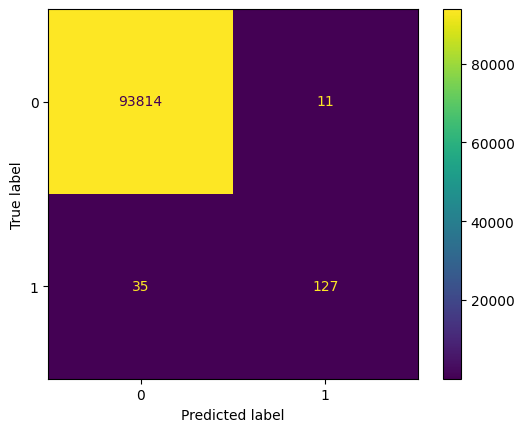

In [15]:

cm = confusion_matrix(y_test, y_pred)
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rnd.classes_)
disp.plot()


- 93,816 instances were correctly classified as the negative class (True Negatives).
- 11 instances were incorrectly classified as the positive class when they were actually negative (False Positives).
- 35 instances were incorrectly classified as the negative class when they were actually positive (False Negatives).
- 127 instances were correctly classified as the positive class (True Positives).

In [16]:
y_pred = clf_rnd.predict(X_test)

# Calculate and display classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.92      0.78      0.85       162

    accuracy                           1.00     93987
   macro avg       0.96      0.89      0.92     93987
weighted avg       1.00      1.00      1.00     93987



In [17]:
import joblib

joblib.dump(value= clf_rnd, filename='RandomForestModel.pkl')

['RandomForestModel.pkl']